In [1]:
# importing necessary packages
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
x = np.arange(0,8,1)    # define some vectors x and y
y = x

print(x)

N = len(x)              
nqubits = math.ceil(np.log2(N))    # compute how many qubits needed to encode either x or y

xnorm = np.linalg.norm(x)          # normalise vectors x and y
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

circ = QuantumCircuit(nqubits+1)   # create circuit
vec = np.concatenate((x,y))/np.sqrt(2)    # concatenate x and y as above, with renormalisation

circ.initialize(vec, range(nqubits+1))
circ.h(nqubits)                    # apply hadamard to bottom qubit

circ.draw()

[0 1 2 3 4 5 6 7]


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                   ├»
«     │                                                                                                                                    │»
«q_1: ┤1                                                                                                                                   ├»
«     │  Initialize(0,0.059761,0.11952,0.17928,0.23905,0.29881,0.35857,0.41833,0,0.059761,0.11952,0.17928,0.23905,0.29881,0.35857,0.41833) │»
«q_2: ┤2                                                                                                                                   ├»
«     │                                                                                                                                    │»
«q_3: ┤3                                                                                                                                   ├»
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«          
«q_0: ─────
«          
«q_1: ─────
«          
«q_2: ─────
«     ┌───┐
«q_3: ┤ H ├
«     └───┘

In [4]:
def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})

    result = job.result()
    o = np.real(result.get_statevector(circ))

    m_sum = 0
    for l in range(N):
        m_sum += o[l]**2
        
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  0.9999999999999998


In [5]:
def calculate_cost_function(parameters):

    a, b = parameters
    
    ansatz = a*x + b                        # compute ansatz
    ansatzNorm = np.linalg.norm(ansatz)     # normalise ansatz
    ansatz = ansatz/ansatzNorm
    
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     # use quantum circuit to test ansatz
                                                           # note the normalisation factors
    return (1-y_ansatz)**2

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
ynorm = np.linalg.norm(y)
y = y/ynorm

a = 1.0
b = 1.0
print("Cost function for a =", a, "and b =", b, "equals:", calculate_cost_function([a,b]))

Cost function for a = 1.0 and b = 1.0 equals: 0.03999999999999981


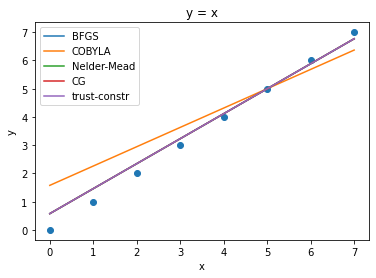

In [6]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = x   # + [random.uniform(-1,1) for p in range(8)]    # can add noise here
N = len(x)
nqubits = math.ceil(np.log2(N))
       
ynorm = np.linalg.norm(y)      # normalise the y data set
y = y/ynorm

x0 = [0.5,0.5]                 # initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

out_a = out['x'][0]
out_b = out['x'][1]

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
x = np.arange(0,8,1)    # define some vectors x and y
y = x

N = len(x)              
nqubits = math.ceil(np.log2(N))    # compute how many qubits needed to encode either x or y

xnorm = np.linalg.norm(x)          # normalise vectors x and y
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

circ = QuantumCircuit(nqubits+1,1)   # create circuit
vec = np.concatenate((x,y))/np.sqrt(2)    # concatenate x and y as above, with renormalisation

circ.initialize(vec, range(nqubits+1))
circ.h(nqubits)                    # apply hadamard to bottom qubit
circ.measure(nqubits,0)            # measure bottom qubit in computational basis

circ.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
c: 1/»
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                   ├»
«     │                                                                                                                                    │»
«q_1: ┤1                                                                                                                                   ├»
«     │  Initialize(0,0.059761,0.11952,0.17928,0.23905,0.29881,0.35857,0.41833,0,0.059761,0.11952,0.17928,0.23905,0.29881,0.35857,0.41833) │»
«q_2: ┤2                                                                                                                                   ├»
«     │                                                                                                                                    │»
«q_3: ┤3                                                                                                                                   ├»
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«c: 1/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                           »
«             
«q_0: ────────
«             
«q_1: ────────
«             
«q_2: ────────
«     ┌───┐┌─┐
«q_3: ┤ H ├┤M├
«     └───┘└╥┘
«c: 1/══════╩═
«           0

In [8]:
def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1,1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)
    circ.measure(nqubits,0)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=20000)

    result = job.result()
    outputstate = result.get_counts(circ)

    if ('0' in outputstate.keys()):
        m_sum = float(outputstate["0"])/20000
    else:
        m_sum = 0
     
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  1.0


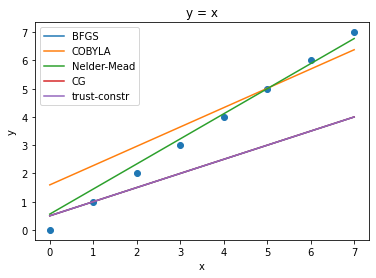

In [9]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = x   # + [random.uniform(-1,1) for p in range(8)]  # can add noise here
N = len(x)
nqubits = math.ceil(np.log2(N))

ynorm = np.linalg.norm(y)    # normalise y data set
y = y/ynorm

x0 = [0.5,0.5]       # initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

out_a = out['x'][0]
out_b = out['x'][1]

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [10]:
# New cost function calculation, allowing for higher order polynomials
# Implements the entire cost function by feeding the ansatz to the quantum circuit which computes inner products
def calculate_cost_function_n(parameters):
    
    ansatz = parameters[0]                   # compute ansatz

    for i in range(1,len(parameters)):

        ansatz += parameters[i] * x**i
        
    ansatzNorm = np.linalg.norm(ansatz)      # normalise ansatz
    ansatz = ansatz/ansatzNorm
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     # use quantum circuit to test ansatz
                                                           # note the normalisation factors

    return (1-y_ansatz)**2

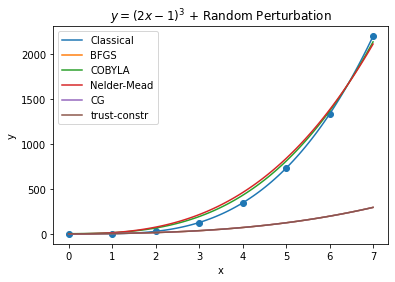

In [11]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = (2*x-1)**3 + [random.uniform(-1,1) for p in range(8)]
N = len(x)
nqubits = math.ceil(np.log2(N))
       
ynorm = np.linalg.norm(y)       #normalise y data set
y = y/ynorm

order = 3

x0 = [random.uniform(0,2) for p in range(order+1)]    #random initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function_n, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function_n, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function_n, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function_n, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function_n, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

class_fit = np.polyfit(x,y*ynorm,order)
class_fit = class_fit[::-1]

xfit = np.linspace(min(x), max(x), 100)

def return_fits(xfit):
    c_fit = np.zeros(100)
    q_fit = np.zeros(100)
    q_fit1 = np.zeros(100)
    q_fit2 = np.zeros(100)
    q_fit3 = np.zeros(100)
    q_fit4 = np.zeros(100)
    for i in range(order+1):
        c_fit += xfit**i*class_fit[i]
        q_fit += xfit**i*out['x'][i]
        q_fit1 += xfit**i*out1['x'][i]
        q_fit2 += xfit**i*out2['x'][i]
        q_fit3 += xfit**i*out3['x'][i]
        q_fit4 += xfit**i*out4['x'][i]
        

    return c_fit, q_fit, q_fit1, q_fit2, q_fit3, q_fit4

c_fit, q_fit, q_fit1, q_fit2, q_fit3, q_fit4 = return_fits(xfit)

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, c_fit, label='Classical')
plt.plot(xfit, q_fit, label='BFGS')
plt.plot(xfit, q_fit1, label='COBYLA')
plt.plot(xfit, q_fit2, label='Nelder-Mead')
plt.plot(xfit, q_fit3, label='CG')
plt.plot(xfit, q_fit4, label='trust-constr')
plt.legend()
plt.title("$y = (2x-1)^3$ + Random Perturbation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()